In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import scale_array

import nengo_encoder_learning as nel

In [2]:
n_neurons = 100
dimensions = 2

In [3]:
n_vecs = 5

rng = np.random.RandomState(seed=8)

vec1 = np.array([1, 1])
clust_vecs = []
for nn in range(n_vecs):
    tmp_vec = vec1 + rng.normal(scale=0.1, size=2)
    tmp_vec /= np.linalg.norm(tmp_vec)
    clust_vecs.append(tmp_vec)

clust_vecs = np.array(clust_vecs)
print(np.linalg.norm(np.mean(clust_vecs)))

vec2 = np.array([-1, -1])
sprd_vecs = []
for nn in range(n_vecs):
    tmp_vec = vec2 + rng.normal(scale=0.5, size=2)
    tmp_vec /= np.linalg.norm(tmp_vec)
    sprd_vecs.append(tmp_vec)

sprd_vecs = np.array(sprd_vecs)
print(np.linalg.norm(np.mean(sprd_vecs)))

0.7031170671088868
0.6604427197034959


(-1.1, 1.1)

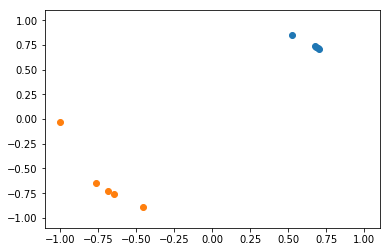

In [4]:
plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster")
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

# Clean vecs

In [5]:
all_vecs = np.concatenate((clust_vecs, sprd_vecs))

In [9]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                         intercepts=nengo.dists.CosineSimilarity(dimensions+2))
    
    output = nengo.Node(size_in=dimensions)
    
    c = nengo.Connection(ens, output, eval_points=all_vecs)

In [10]:
res, gain = nel.improve_with_hist(c, learning_rate=1e-2, steps=1100, seed=0)

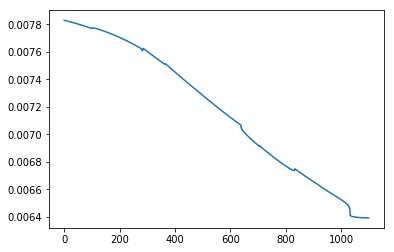

In [11]:
plt.plot(res["error"])

In [12]:
enc = np.array(res["encoders"])

In [13]:
diff = np.sum(np.sum(np.abs(np.diff(enc, axis=0)), axis=0), axis=1)
diff_idx = np.argsort(diff)

(-1.1, 1.1)

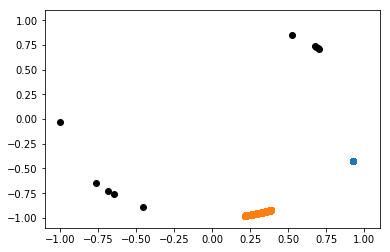

In [14]:
plt.scatter(enc[:, diff_idx[0], 0], enc[:, diff_idx[1], 1])
plt.scatter(enc[:, diff_idx[-1], 0], enc[:, diff_idx[-1], 1])
plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster", color='k')
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread", color='k')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [15]:
# activ, dec, err = nel.batch.forward_pass(enc[-1], gain, res["bias"][-1], all_vecs, all_vecs,
#                                          nengo.LIF, np.random.RandomState(seed=8))
# print(err)

with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                         encoders=enc[-1], gain=gain, bias=res["bias"][-1])
#     output = nengo.Node(size_in=dimensions)
    
#     c = nengo.Connection(ens, output, transform=dec)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [17]:
_, activity_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=clust_vecs)
_, activity_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=sprd_vecs)

columns = ("vec", "resp")

a1 = activity_1.flatten()
l1 = ["clust"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_2.flatten()
l2 = ["spread"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

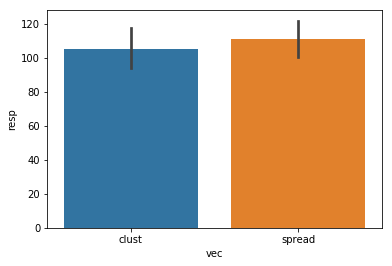

In [18]:
sns.barplot(x="vec", y="resp", data=acts)

# Noisier vecs

In [38]:
clust_eval = []
clust_func = []
sprd_eval = []
sprd_func = []


mag = 0.1

for n in range(200):
    clust_eval.append(clust_vecs + np.random.normal(size=clust_vecs.shape) * mag)
    clust_func.append(clust_vecs)

    sprd_eval.append(sprd_vecs + np.random.normal(size=sprd_vecs.shape) * mag)
    sprd_func.append(sprd_vecs)

clust_eval = np.concatenate(clust_eval)
clust_eval /= np.linalg.norm(clust_eval, axis=1, keepdims=True)
clust_func = np.concatenate(clust_func)

sprd_eval = np.concatenate(sprd_eval)
sprd_eval /= np.linalg.norm(sprd_eval, axis=1, keepdims=True)
sprd_func = np.concatenate(sprd_func)

(-1.1, 1.1)

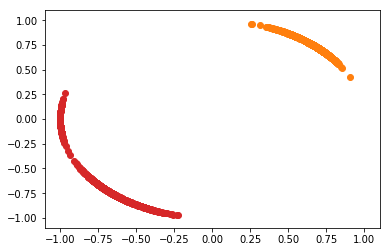

In [39]:
plt.scatter(clust_func[:, 0], clust_func[:, 1], label="cluster")
plt.scatter(clust_eval[:, 0], clust_eval[:, 1], label="noised cluster")
plt.scatter(sprd_func[:, 0], sprd_func[:, 1], label="spread")
plt.scatter(sprd_eval[:, 0], sprd_eval[:, 1], label="noised spread")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [40]:
eval_points = np.concatenate((clust_eval, sprd_eval))
print(eval_points.shape)

func = np.concatenate((clust_func, sprd_func))
print(func.shape)

(2000, 2)
(2000, 2)


In [41]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                         intercepts=nengo.dists.CosineSimilarity(dimensions+2))
    
    output = nengo.Node(size_in=dimensions)
    
    c = nengo.Connection(ens, output, eval_points=eval_points, function=func)

In [42]:
res, gain = nel.improve_with_hist(c, learning_rate=1e-3, steps=3000, seed=0)

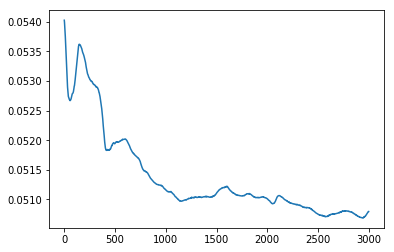

In [43]:
plt.plot(res["error"])

In [44]:
enc = np.array(res["encoders"])

In [45]:
diff = np.sum(np.sum(np.abs(np.diff(enc, axis=0)), axis=0), axis=1)
diff_idx = np.argsort(diff)

(-1.1, 1.1)

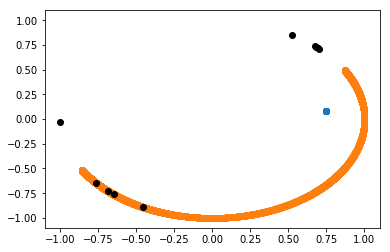

In [46]:
plt.scatter(enc[:, diff_idx[0], 0], enc[:, diff_idx[1], 1])
plt.scatter(enc[:, diff_idx[-1], 0], enc[:, diff_idx[-1], 1])
plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster", color='k')
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread", color='k')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

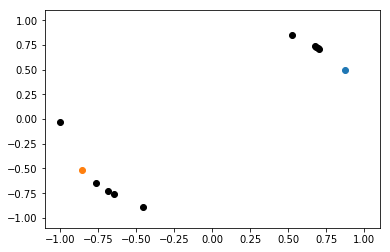

In [47]:
plt.scatter(enc[0, diff_idx[-1], 0], enc[0, diff_idx[-1], 1])
plt.scatter(enc[-1, diff_idx[-1], 0], enc[-1, diff_idx[-1], 1])
plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster", color='k')
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread", color='k')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

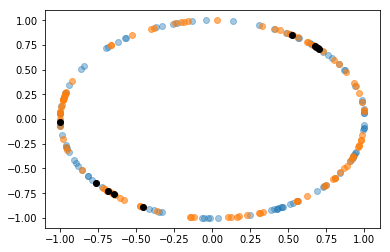

In [48]:
plt.scatter(enc[0, :, 0], enc[0, :, 1], alpha=0.4)
plt.scatter(enc[-1, :, 0], enc[-1, :, 1], alpha=0.6)
plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster", color='k')
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread", color='k')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

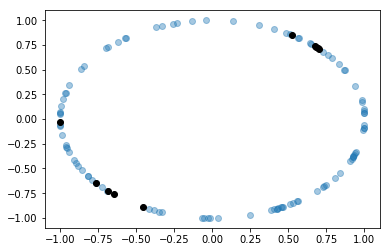

In [49]:
plt.scatter(enc[0, :, 0], enc[0, :, 1], alpha=0.4)
plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster", color='k')
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread", color='k')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

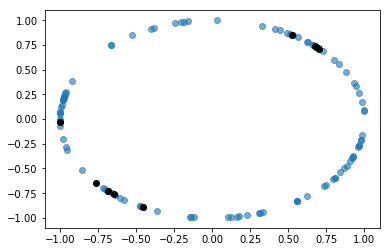

In [50]:
plt.scatter(enc[-1, :, 0], enc[-1, :, 1], alpha=0.6)
plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster", color='k')
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread", color='k')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

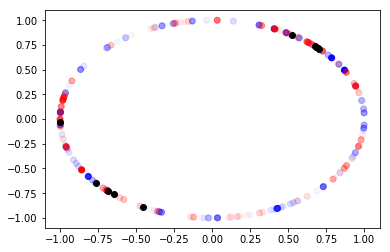

In [51]:
last_colors = np.zeros((enc.shape[1], 4))
last_colors[:, 0] = 1
last_colors[:, 3] = scale_array(diff, out_range=(0, 1))

first_colors = np.zeros((enc.shape[1], 4))
first_colors[:, 2] = 1
first_colors[:, 3] = scale_array(diff, out_range=(0, 1))

plt.scatter(enc[0, :, 0], enc[0, :, 1], color=first_colors)
plt.scatter(enc[-1, :, 0], enc[-1, :, 1], color=last_colors)
plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster", color='k')
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread", color='k')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [52]:
# activ, dec, err = nel.batch.forward_pass(enc[-1], gain, res["bias"][-1], all_vecs, all_vecs,
#                                          nengo.LIF, np.random.RandomState(seed=8))
# print(err)

with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                         encoders=enc[-1], gain=gain, bias=res["bias"][-1])
#     output = nengo.Node(size_in=dimensions)
    
#     c = nengo.Connection(ens, output, transform=dec)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [53]:
_, activity_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=clust_vecs)
_, activity_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=sprd_vecs)

columns = ("vec", "resp")

a1 = activity_1.flatten()
l1 = ["clust"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_2.flatten()
l2 = ["spread"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

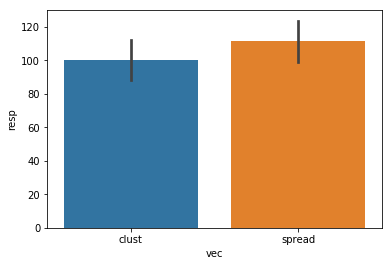

In [54]:
sns.barplot(x="vec", y="resp", data=acts)